# 🫀 Heart Disease Prediction and Interpretability

This notebook demonstrates a complete machine learning pipeline applied to the UCI Heart Disease dataset. All models and tools are implemented from scratch, including:

- Logistic Regression
- Decision Tree
- Random Forest
- LIME (Local Interpretable Model-Agnostic Explanations)

The goal is both predictive performance and interpretability — understanding **why** the model made a prediction.


## 🔧 Setup and Imports

We begin by importing all required modules from our custom `courselib` framework.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import shap

# Custom modules (all implemented from scratch)
from courselib.utils.loaders import load_heart_data
from courselib.utils.preprocessing import preprocess_dataframe
from courselib.utils.normalization import minmax_normalize
from courselib.utils.splits import train_test_split
from courselib.utils.metrics import accuracy, f1_score, mean_squared_error, binary_accuracy
from courselib.models.logistic import LogisticRegression
from courselib.models.tree import DecisionTree
from courselib.models.forest import RandomForest
from courselib.optimizers import GDOptimizer, MomentumOptimizer
from courselib.explain.lime import LimeTabularExplainer, run_lime_multiple_times, plot_lime_aggregated
from courselib.utils.summarization import summarize_after_preprocessing
from courselib.utils.cv import grid_search_cv


## 📥 Load and Preprocess Data

We use the UCI Heart Disease dataset, which includes patient data (e.g. age, sex, cholesterol, etc.) and a target variable indicating presence (1-4) or absence (0) of heart disease (Source: https://archive.ics.uci.edu/dataset/45/heart+disease). 

> ### 💡 Binary Transformation
>
> The target ranges from 0 to 4:
> - 0 = no presence of heart disease
> - 1–4 = presence of heart disease  
>  
> Our research focuses on the binary classification task: **presence (1–4) vs. absence (0)** as described in the dataset information.
> So we convert:
>
> $$
> y = \begin{cases}
>     0 & \text{if } y = 0 \\\\
>     1 & \text{if } y \in \{1, 2, 3, 4\}
> \end{cases}
> $$

Steps:
- Fetch dataset
- Convert multiclass to binary target
- Encode categorical features
- Normalize numerical features to [0, 1] range
- Split into training and testing sets


In [3]:
# Load raw data
X_df, y_series = load_heart_data()

# Convert target to binary: 0 (no disease), 1 (disease)
y_series = (y_series > 0).astype(int)

# Create a complete DataFrame with features and target
df_complete = pd.concat([X_df, y_series], axis=1)

# Combine and preprocess
X, y = preprocess_dataframe(df_complete, target_col= "num")

# Normalize features
X = minmax_normalize(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, seed=42)

# Summarize the dataset after preprocessing
summarize_after_preprocessing(df_complete, X=X, X_train=X_train, X_test=X_test)


🧼 Dropping rows with missing values:
  - ca: 4 missing
  - thal: 2 missing
🧹 Total rows dropped: 6

📦 Train/test split:
  Training samples: 237
  Test samples:     60

🧾 Binary target distribution:
  Class 0: 164 samples (54.1%)
  Class 1: 139 samples (45.9%)

🔢 Feature matrix shape: 297 samples × 13 features


### Covariate Overview

This dataset contains 14 key attributes related to heart disease diagnosis. The primary covariates include:

- **age**: Patient age in years  
- **sex**: Gender (1 = male; 0 = female)  
- **cp**: Chest pain type (4 values)  
- **trestbps**: Resting blood pressure (in mm Hg)  
- **chol**: Serum cholesterol (in mg/dl)  
- **fbs**: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)  
- **restecg**: Resting ECG results (values 0–2)  
- **thalach**: Maximum heart rate achieved  
- **exang**: Exercise-induced angina (1 = yes; 0 = no)  
- **oldpeak**: ST depression induced by exercise  
- **slope**: Slope of the peak exercise ST segment  
- **ca**: Number of major vessels colored by fluoroscopy (0–3)  
- **thal**: Thalassemia (3 = normal; 6 = fixed defect; 7 = reversible defect)  
- **target**: Presence of heart disease (1 = yes; 0 = no)

_Source: [UCI Heart Disease Dataset](https://archive.ics.uci.edu/dataset/45/heart+disease)_


## 📈 Logistic Regression

We implement logistic regression using gradient descent.

> ### 💡 Model and Loss
>
> The model computes probabilities as:
>
> $$
> \hat{y}_i = \sigma(w^T x_i + b), \quad \text{where} \quad \sigma(z) = \frac{1}{1 + e^{-z}}
> $$
>
> The loss function is binary cross-entropy:
>
> $$
> \mathcal{L}(w, b) = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
> $$
>
> Optimized using gradient descent.


In [4]:
optimizer = GDOptimizer(learning_rate=1e-3)
logreg = LogisticRegression(
    w=np.zeros(X_train.shape[1]), 
    b=0.0, 
    optimizer=optimizer, 
    penalty="none"
)

accuracy = lambda y_true,y_pred: binary_accuracy(y_true,y_pred,class_labels=[0,1])
metrics_dict = {'accuracy': accuracy,
                'MSE': mean_squared_error}
metrics_history = logreg.fit(X_train, y_train, num_epochs=150000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

y_pred_logreg = logreg(X_test)
print(f"Logistic Regression Accuracy: {accuracy(y_test, y_pred_logreg):.3f}%")

Logistic Regression Accuracy: 81.667%


The final train accuracy: 84.388%
Test accuracy: 81.667%


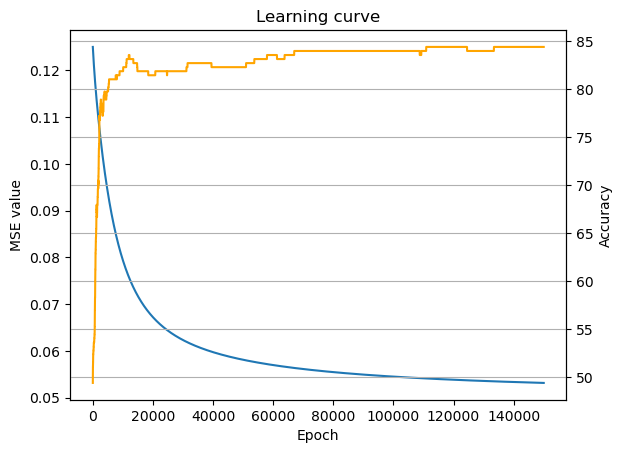

In [5]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['MSE'])), metrics_history['MSE'])
ax.set_ylabel('MSE value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {metrics_history["accuracy"][-1]:.3f}%')
print(f'Test accuracy: {accuracy(logreg(X_test), y_test):.3f}%')

### 🧠 **Bonus: Accelerating Logistic Regression with Momentum**

Training deep or even shallow models using vanilla gradient descent can often be **slow to converge**, especially in the presence of noisy gradients or shallow slopes. One widely used remedy is **gradient descent with momentum**, which accumulates a velocity vector to smooth updates and speed up convergence.

By incorporating a `MomentumOptimizer` into our logistic regression setup, we aim to:

- Mitigate oscillations in flat or curved loss surfaces  
- Accelerate convergence to minima  
- Potentially reach better-performing solutions in fewer steps  

In the following, we swap out `GDOptimizer` for a `MomentumOptimizer` with `momentum=0.9` and track its effect on performance and convergence.


In [6]:
optimizer = MomentumOptimizer(learning_rate=1e-3, momentum=0.9)

logreg_momentum = LogisticRegression(
    w=np.zeros(X_train.shape[1]), 
    b=0.0, 
    optimizer=optimizer, 
    penalty="none"
)

accuracy = lambda y_true,y_pred: binary_accuracy(y_true,y_pred,class_labels=[0,1])
metrics_dict = {'accuracy': accuracy,
                'MSE': mean_squared_error}
metrics_history_momentum = logreg_momentum.fit(X_train, y_train, num_epochs=25000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

y_pred_logreg_momentum = logreg_momentum(X_test)
print(f"Logistic Regression Accuracy: {accuracy(y_test, y_pred_logreg_momentum):.3f}%")

Logistic Regression Accuracy: 81.667%


The final train accuracy: 84.810%
Test accuracy: 81.667%


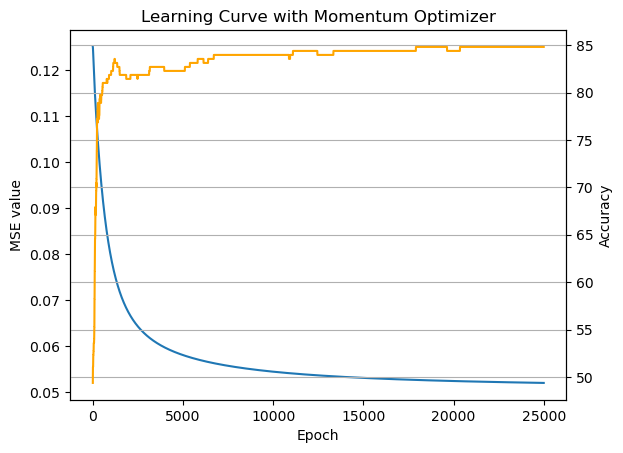

In [7]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history_momentum['MSE'])), metrics_history_momentum['MSE'])
ax.set_ylabel('MSE value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history_momentum['accuracy'])), metrics_history_momentum['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning Curve with Momentum Optimizer')
plt.grid()

print(f'The final train accuracy: {metrics_history_momentum["accuracy"][-1]:.3f}%')
print(f'Test accuracy: {accuracy(logreg_momentum(X_test), y_test):.3f}%')

### 📊 **Result Summary: Momentum Accelerates Convergence**

The plots below clearly illustrate the benefit of adding momentum to gradient descent:

- The **standard GDOptimizer** required nearly **100,000 epochs** before the MSE stabilized around 0.053
- In contrast, the **MomentumOptimizer converged in around 15,000 epochs**, reaching the same MSE value roughly **6x faster**
- Both models achieved a similar **final test accuracy of 81.67%**, but the momentum-based model got there significantly quicker and with smoother optimization

This confirms that momentum helps **escape slow descent regions and accelerates convergence**, making it a valuable upgrade for iterative optimization — even in classic models like logistic regression.


## 🌳 Decision Tree

Decision trees recursively split the data to reduce impurity and create interpretable decision rules.

> ### 💡 Impurity Measures
>
> Gini impurity:
>
> $$
> G = 1 - \sum_{k=1}^K p_k^2
> $$
>
> Entropy:
>
> $$
> H = -\sum_{k=1}^K p_k \log(p_k)
> $$
>
> A split is chosen to minimize weighted impurity across child nodes.

---

We tune the **`max_depth`** hyperparameter via **grid search** with **5-fold cross-validation**, optimizing for classification **accuracy**.

This helps prevent overfitting while selecting a performant, interpretable tree depth.


In [8]:
# Grid search for best tree depth using cross-validation
param_grid = {"max_depth": [2, 3, 4, 5, 6]}
best_tree, best_params, best_score = grid_search_cv(
    ModelClass=DecisionTree,
    param_grid=param_grid,
    X=X_train,
    y=y_train,
    metric_fn=accuracy,
    k=5,
    seed=42
)

# Evaluate best model on test set
y_pred_tree = best_tree.predict(X_test)
print(f"✅ Decision Tree (best CV depth = {best_params['max_depth']}):")
print(f"CV Accuracy: {best_score:.3f}%")
print(f"Test Accuracy: {accuracy(y_test, y_pred_tree):.3f}%")

✅ Decision Tree (best CV depth = 3):
CV Accuracy: 75.931%
Test Accuracy: 70.000%


## 🌲 Random Forest

Random forests are ensembles of decision trees, trained on random subsets of the data and features.

> ### 💡 Key Idea
>
> Combine multiple weak learners (trees) to create a strong learner.  
> Each tree votes, and the majority decision is the output.  
> This improves generalization and reduces variance.

---

We tune two key hyperparameters using **grid search** and **5-fold cross-validation**:

- `n_estimators`: the number of trees in the forest  
- `max_depth`: maximum depth allowed for each tree

We evaluate using **classification accuracy**.


In [9]:
# Define parameter grid
rf_param_grid = {
    "n_estimators": [10, 20, 50],
    "max_depth": [3, 4, 5],
}

# Perform grid search
best_forest, best_rf_params, best_rf_score = grid_search_cv(
    ModelClass=RandomForest,
    param_grid=rf_param_grid,
    X=X_train,
    y=y_train,
    metric_fn=accuracy,
    k=5,
    seed=42
)

# Evaluate on test set
y_pred_forest = best_forest.predict(X_test)

print(f"✅ Best Random Forest Parameters: {best_rf_params}")
print(f"CV Accuracy: {best_rf_score:.3f}%")
print(f"Test Accuracy: {accuracy(y_test, y_pred_forest):.3f}%")

✅ Best Random Forest Parameters: {'n_estimators': 50, 'max_depth': 5}
CV Accuracy: 80.594%
Test Accuracy: 83.333%


## 🚀 XGBoost Classifier

XGBoost is an efficient and scalable implementation of **gradient boosting**, a technique where models are built sequentially to correct the residuals of prior models.

> ### 💡 Boosting vs. Bagging
>
> Unlike random forests (which use **bagging**, training trees independently on resampled data), **boosting** combines weak learners in a sequential, additive manner:
>
> $$
> f(x) = \sum_{t=1}^T \eta \cdot h_t(x), \quad \text{where } h_t \text{ is a decision tree and } \eta \in (0, 1] \text{ as the learning rate}
> $$
>
> Each new tree $( h_t )$ is trained to predict the negative gradient of the loss function.

---

We use the official `xgboost.XGBClassifier` for performance, stability, and compatibility with SHAP.

To optimize predictive performance, we apply **grid search** with **5-fold cross-validation**, tuning:

- `n_estimators`: number of boosting rounds  
- `max_depth`: depth of individual trees  
- `learning_rate`: shrinkage factor applied to each boosting step

This model serves as a **performance benchmark** for comparison with simpler interpretable models.


In [10]:
# Use scikit-learn compatible wrapper
xgb_model = xgb.XGBClassifier(eval_metric="logloss", random_state=42)

# Grid of hyperparameters
xgb_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1]
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring=make_scorer(accuracy),
    cv=5,
    verbose=0
)

grid.fit(X_train, y_train)
best_xgb = grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("✅ Best XGBoost Parameters:", grid.best_params_)
print(f"Test Accuracy (XGBoost): {accuracy(y_test, y_pred_xgb):.3f}")

✅ Best XGBoost Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 50}
Test Accuracy (XGBoost): 83.333


## 🔬 Model Comparison

To evaluate model performance, we compare test accuracy across all classifiers:

- ✅ Logistic Regression (from scratch)
- 🌳 Decision Tree (from scratch, tuned via CV)
- 🌲 Random Forest (from scratch, CV-tuned ensemble)
- 🚀 XGBoost (grid search tuned)

| Model               | Accuracy |
|---------------------|----------|
| Logistic Regression | TBD      |
| Decision Tree       | TBD      |
| Random Forest       | TBD      |
| XGBoost             | TBD      |  
    
   
> Additionally, we compare interpretability:

- LIME provides local sparse linear approximations
- SHAP gives consistent, additive feature attributions

Both tools help identify the most influential features, but differ in fidelity and stability.


## 🔍 LIME: Local Interpretable Model-Agnostic Explanations

We use LIME to explain predictions made by our tuned **Random Forest model (`best_forest`)** on individual instances.

LIME explains any black-box model by fitting a simple surrogate (e.g., linear regression) locally around the point of interest.

> ### 💡 Algorithm Overview
>
> 1. Generate perturbed samples $z_i$ around the target input $x_0$
> 2. Evaluate the Random Forest's prediction $f(z_i)$ for each
> 3. Compute locality-aware weights $\pi_{x_0}(z_i)$ based on distance
> 4. Fit a weighted linear model $g$ to approximate $f$ near $x_0$
> 5. Use the coefficients $\phi_i$ of $g$ as feature attributions

---

### 🎯 Optimization Objective

LIME solves the following local surrogate loss:

$$
\xi(x_0) = \arg\min_{g \in G} \sum_{i=1}^n \pi_{x_0}(z_i) \cdot (f(z_i) - g(z_i))^2 + \Omega(g)
$$

- $\pi_{x_0}(z_i)$ is an exponential kernel centered at $x_0$
- $\Omega(g)$ is a regularization term, here implemented via ridge regression
- The surrogate $g$ is an interpretable linear model fit to locally sampled data

---

We use our own `LimeTabularExplainer` and `RidgeRegression` to compute these attributions for a selected test instance. The `best_forest` model outputs binary predictions, which LIME approximates using local linear regression.

This approach provides insight into how individual features contribute to a specific decision made by the Random Forest model.


In [ ]:
# TO DELETE









import numpy as np

# Assume: X_train, X_test, logreg, and LimeTabularExplainer are already defined

# 1. Check shape and validity of X_train
print("✅ X_train shape:", X_train.shape)
print("✅ Any NaNs in X_train?", np.isnan(X_train).any())

# 2. Initialize explainer and print internal stats
explainer = LimeTabularExplainer(X_train, feature_names=X_df.columns.tolist(), kernel_width=1.0)
print("✅ Feature std (min/max):", np.min(explainer.feature_std), np.max(explainer.feature_std))

# 3. Pick instance and generate perturbations manually
instance = X_test[5]
num_samples = 300
perturbed = np.random.normal(loc=instance, scale=explainer.feature_std, size=(num_samples, len(instance)))
perturbed = np.clip(perturbed, 0, 1)
perturbed = np.vstack([instance, perturbed])

print("✅ Perturbed shape:", perturbed.shape)
print("✅ Perturbed sample stats [first row]:", perturbed[0])

# 4. Run model predictions
predict_fn = lambda x: logreg.decision_function(np.atleast_2d(x)).flatten()
preds = predict_fn(perturbed)
print("✅ Predictions shape:", preds.shape)
print("✅ Prediction stats:", np.min(preds), np.max(preds), np.unique(preds[:10]))

# 5. Compute distances and sample weights
distances = np.linalg.norm((perturbed - instance) / explainer.feature_std, axis=1)
weights = np.exp(-distances ** 2 / explainer.kernel_width ** 2)
print("✅ Sample weights stats:", np.min(weights), np.max(weights), np.mean(weights))

# 6. Test RidgeRegression stability
from courselib.models.ridge import RidgeRegression
ridge = RidgeRegression(alpha=1.0, fit_intercept=True)
try:
    ridge.fit(perturbed, preds, sample_weight=weights)
    print("✅ Ridge fit: success")
    print("✅ Coef preview:", ridge.coef_[:5])
except Exception as e:
    print("❌ Ridge fit error:", e)


✅ X_train shape: (237, 13)
✅ Any NaNs in X_train? False
✅ Feature std (min/max): 0.11310354958411033 0.49565040043363123
✅ Perturbed shape: (301, 13)
✅ Perturbed sample stats [first row]: [0.6875     0.         1.         0.41509434 0.38356164 1.
 0.         0.26717557 0.         0.30645161 0.5        1.
 0.        ]
✅ Predictions shape: (301,)
✅ Prediction stats: 0.2607459581803548 0.988225208938951 [0.54016324 0.69339579 0.73513983 0.75392156 0.76135849 0.87899659
 0.87913271 0.89916886 0.91991434 0.94035689]
✅ Sample weights stats: 1.979641479527381e-13 1.0 0.009290366050335236
✅ Ridge fit: success
✅ Coef preview: [-8.54924041e-04  7.20743520e-03  2.55528257e-03 -2.57183781e-06
  4.48971086e-04]


In [52]:
explainer = LimeTabularExplainer(X_train, feature_names=X_df.columns.tolist())
instance = X_test[15]
predict_fn = lambda x: best_forest(x)
weights, idx = explainer.explain_instance(instance, predict_fn, num_samples=1250)

print("Top LIME Features:")
for feat, w in explainer.as_list(weights, idx, top_k=7):
    print(f"{feat}: {w:.4f}")

Top LIME Features:
thal: 0.0379
cp: 0.0344
exang: 0.0263
restecg: -0.0247
ca: 0.0199
oldpeak: 0.0186
trestbps: 0.0138


## 📊 LIME Stability: Comparing Explanations Across Models

LIME uses local perturbations to explain individual model predictions — but its output can vary due to randomness in sampling. To address this, we apply LIME **multiple times** and aggregate the results.

> ### 💡 Why Aggregate?
>
> Running LIME repeatedly helps identify which features are **consistently important** and which fluctuate due to sampling noise.  
> This improves the reliability of explanations and enables fair comparison between models.

---

We explain a **single test instance** using both:

- **Random Forest (`best_forest`)**
- **XGBoost (`best_xgb`)**

For each model, we run LIME **50 times**, generating **1250 perturbations** per run. This configuration strikes a balance between:

- Sufficient **perturbation diversity** within each run
- Meaningful **variability assessment** across runs
- Reasonable **computational cost**

We then compute the **mean ± standard deviation** of the learned feature weights.  
The resulting bar plots highlight the **top 7 features** by average importance, and allow us to compare how each model reasons about the same prediction — with uncertainty visualized explicitly.

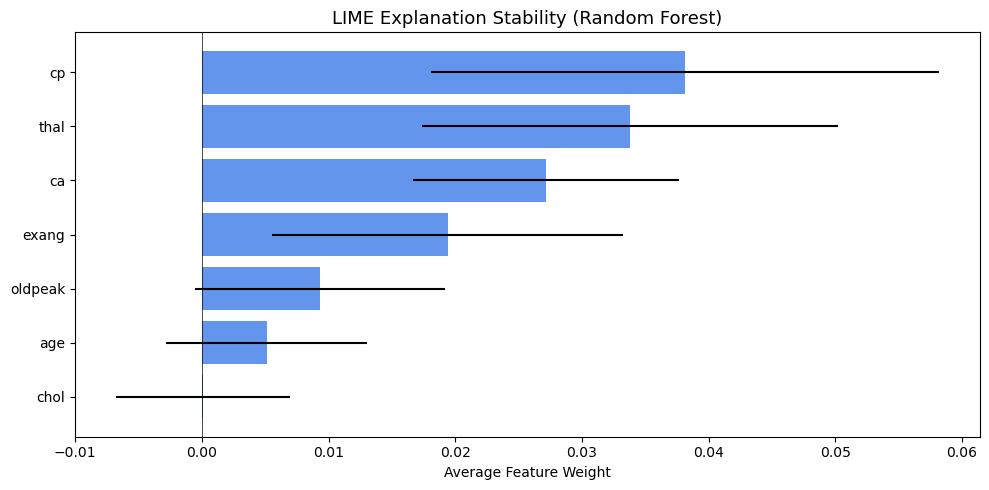

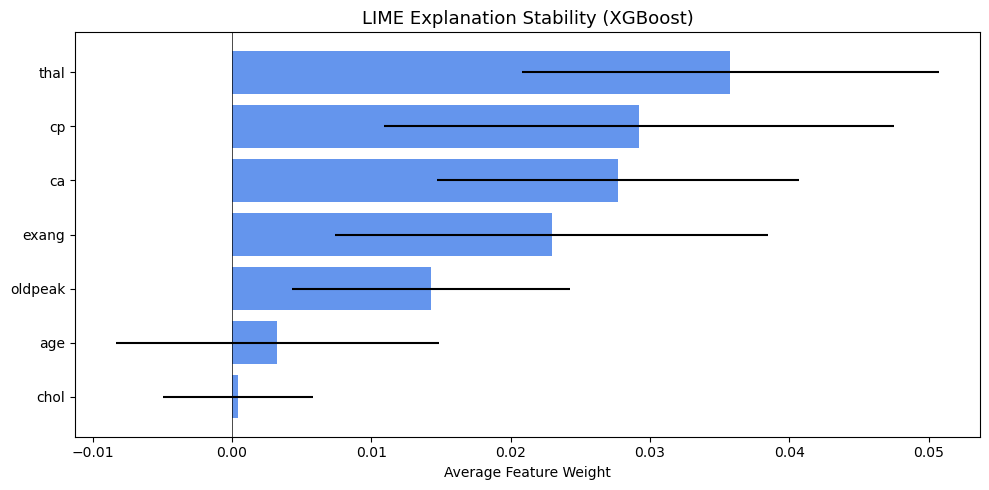

In [45]:
# Select instance and features
instance_idx = 15
instance = X_test[instance_idx]
feature_names = X_df.columns.tolist()

# Define prediction function (example: XGBoost class 1 prob)
predict_fn_random_forest = lambda x: best_forest(x)
predict_fn_xgboost = lambda x: best_xgb.predict_proba(np.atleast_2d(x))[:, 1]

# Initialize explainer
explainer = LimeTabularExplainer(X_train, feature_names=feature_names)

# --------------------------------------------------
# Run LIME for Random Forest
means, stds, top_feats = run_lime_multiple_times(explainer=explainer, instance=instance, model_predict_fn=predict_fn_random_forest, 
                                                 feature_names=feature_names, n_runs=50, num_samples=1250, top_k=7)

# Plot results
plot_lime_aggregated(top_means=means, top_stds=stds, top_features=top_feats, title="LIME Explanation Stability (Random Forest)")

# --------------------------------------------------
# Run LIME for XGBoost
means, stds, top_feats = run_lime_multiple_times(explainer=explainer, instance=instance, model_predict_fn=predict_fn, 
                                                 feature_names=feature_names, n_runs=50, num_samples=1250, top_k=7)

# Plot results
plot_lime_aggregated(top_means=means, top_stds=stds, top_features=top_feats, title="LIME Explanation Stability (XGBoost)")

In [ ]:
# Alternative: Increase the number of samples in a single run for more stable results
weights_increased_sample, idx_increased_sample = explainer.explain_instance(instance, predict_fn, num_samples=25000)

print("Top LIME Features:")
for feat, w in explainer.as_list(weights_increased_sample, idx_increased_sample, top_k=7):
    print(f"{feat}: {w:.4f}")

Top LIME Features:
thal: 0.3667
ca: 0.3558
cp: 0.3172
oldpeak: 0.2814
thalach: -0.1552
exang: 0.1447
trestbps: -0.0509


## 🧠 SHAP Explanations for Tree Models

SHAP (SHapley Additive exPlanations) is a unified framework for interpreting individual model predictions using **Shapley values** from cooperative game theory.

> Each feature is assigned a value $\phi_i$ representing its contribution to the prediction, based on all possible feature combinations.

---

### 💡 Mathematical Formulation

A model’s prediction for input $x$ is decomposed as:

$$
f(x) = \phi_0 + \sum_{i=1}^M \phi_i
$$

- $\phi_0$ is the base value (mean model output over the training set)
- $\phi_i$ is the Shapley value of feature $i$, computed as a **weighted average of its marginal contributions** across all subsets

---

### 🔍 Key Properties

- **Local accuracy**: Decomposition holds exactly for the prediction
- **Consistency**: If a feature’s contribution increases, its $\phi_i$ does too
- **Missingness**: Features not in the model get $\phi_i = 0$

---

We use `Explainer`, which efficiently computes exact SHAP values for tree-based models like **XGBoost** and **Random Forests**.

In the plots below:

- The **bar plot** shows global importance (mean $|\phi_i|$ across the test set)
- The **waterfall plot** shows a **local explanation** for a single prediction (test instance #1), starting from $\phi_0$ and accumulating effects of each feature

## 🧠 SHAP Explanations for Tree Models

SHAP (SHapley Additive exPlanations) is a unified framework for interpreting model predictions based on Shapley values from game theory.

> We use `TreeExplainer`, optimized for models like XGBoost and Random Forests.

Key properties of SHAP:

- **Local accuracy**: prediction = base value + sum of SHAP values
- **Consistency**: more influential features get higher importance
- **Missingness**: irrelevant features have 0 contribution

We visualize the **global importance** of features and the **per-instance explanations** for the best XGBoost classifier.


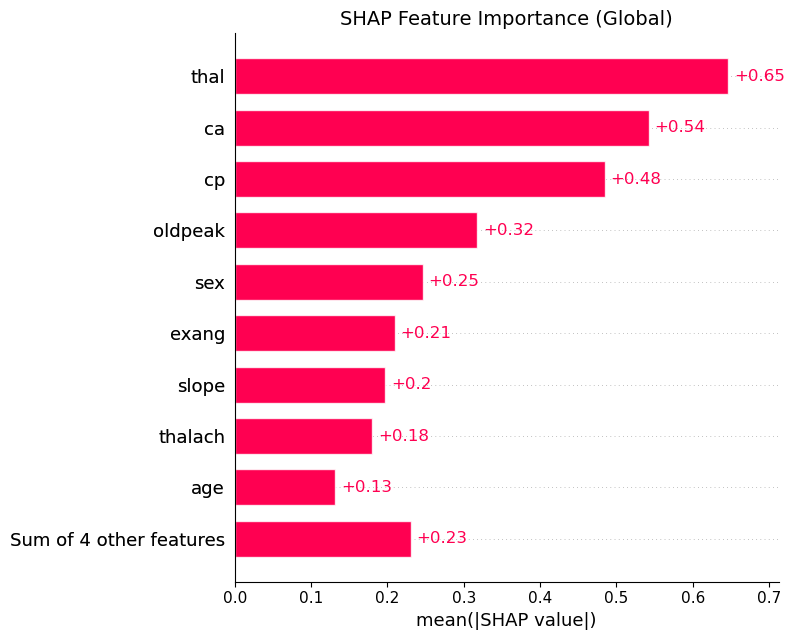

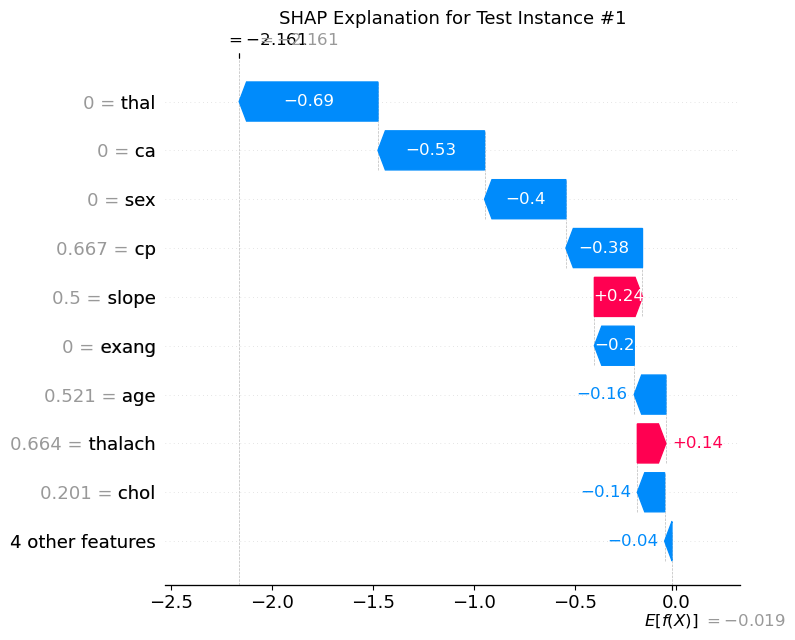

In [54]:
# Ensure DataFrame with feature names
feature_names = X_df.columns.tolist()
X_test_named = pd.DataFrame(X_test, columns=feature_names)

# Use Explainer for XGBoost
explainer = shap.Explainer(best_xgb, feature_names=feature_names)
shap_values = explainer(X_test_named)

# -------- Global Bar Plot (Top features) --------
plt.figure(figsize=(8, 6))
shap.plots.bar(shap_values, max_display=10, show=False)
plt.title("SHAP Feature Importance (Global)", fontsize=14)
plt.tight_layout()
plt.show()

# -------- Local Waterfall Plot --------
instance_idx = 1
plt.figure(figsize=(9, 5))
shap.plots.waterfall(shap_values[instance_idx], show=False)
plt.title(f"SHAP Explanation for Test Instance #{instance_idx}", fontsize=13)
plt.tight_layout()
plt.show()


### 🧠 SHAP Results Summary

The SHAP analysis provides both global and local explanations of how the XGBoost model predicts heart disease.

---

#### 🔍 Global Importance

The bar plot shows the **average absolute SHAP value** of each feature across the test set. Key findings:

- `thal` (thalassemia test result), `ca` (number of major vessels), and `cp` (chest pain type) are the **most important features**

---

#### 📍 Local Explanation for Instance #1

The waterfall plot shows how features contributed to the model's prediction for a specific patient:

- Negative contributions (in blue) from `thal`, `ca`, and `sex` push the prediction toward **no disease**
- Positive contributions (in red), such as `cp` and `slope`, slightly increase the prediction
- The final predicted probability is much lower than the dataset average, indicating a low-risk classification

---

SHAP provides **transparent, additive, and consistent** explanations that align with medical understanding, making it a valuable tool for model validation in healthcare.


## ✅ Summary

We implemented and interpreted multiple models from scratch:

- 🧮 Logistic Regression (with gradients and sigmoid)
- 🌳 Decision Tree (using impurity criteria)
- 🌲 Random Forest (ensemble of trees)
- 🔍 LIME (local explanations with RidgeRegression)

All within a modular framework designed for transparency and learning.
